### Recognizing hand written digits

* Example adopted from [scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py)

* Train a SVM classifier to recognize hand written digits from [0-9]

* Datasets consists of `8x8` pixel images of digits

In [1]:
import covalent as ct
from sklearn import datasets, svm, metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### Break the training/model building into discrete steps

1. Load and prepare the dataset

2. Instantiate a base classifier

3. Split entire dataset into `training` and `test` sets

4. Train the classifier using the `training` set

5. Get predictions using the `test` set

6. Generate classification report

### Load the dataset


In [2]:
@ct.electron
def load_dataset():
    return datasets.load_digits()

### Instantiate a SVM classifier

In [3]:
@ct.electron
def build_classifier(gamma: float):
    return svm.SVC(gamma = gamma)

### Split the dataset into train/test splits

In [4]:
@ct.electron
def split_data(features, targets, test_set_size):
    x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=test_set_size, shuffle=False)
    return x_train, x_test, y_train, y_test

### Train the classifier

In [5]:
@ct.electron
def train_classifier(clf, features, targets):
    return clf.fit(features, targets)

### Get model predictions

In [6]:
@ct.electron
def get_predictions(clf, test_features):
    return clf.predict(test_features)

### Generate classification report

In [7]:
@ct.electron
def get_classification_report(y_test, predictions):
    return metrics.classification_report(y_test, predictions)

### Build the ML workflow

In [8]:
@ct.lattice
def classify_digits(gamma: float):
    dataset = load_dataset()
    clf = build_classifier(gamma)
    x_train, x_test, y_train, y_test = split_data(features=dataset.data, targets=dataset.target, test_set_size=0.5)
    clf = train_classifier(clf, features=x_train, targets=y_train)
    predictions = get_predictions(clf, x_test)
    clf_report = get_classification_report(y_test, predictions)
    return y_test, predictions, clf_report

#### Workflow graph

![SVM workflow](./assets/svm_ml_workflow.png)

### Dispatch the training workflow

In [9]:
dispatch_id = ct.dispatch(classify_digits)(gamma=0.001)

In [10]:
result = ct.get_result(dispatch_id=dispatch_id, wait=True)

In [11]:
y_test, predictions, clf_report = result.result

#### Classification report

In [12]:
print(clf_report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899



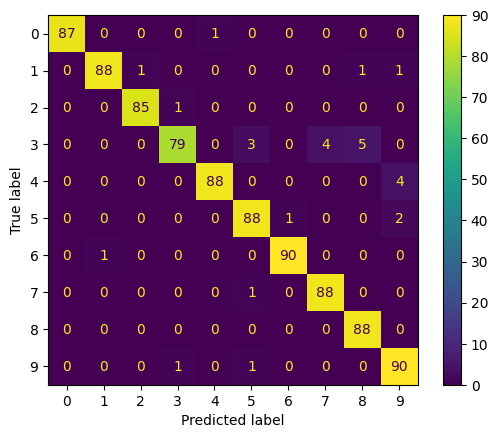

In [13]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions)

## Sublattices

In the above example, we arbitrarily chose $\gamma = 0.001$ for the classifier, however this may not the be most optimial choice for this parameter. In machine learning, hyper-parameter optimization is a crucial step in improving the model's performance and to find the subset of parameters that yield the best predictor/classifier.

With `Covalent` iterating exsiting workflows and making them larger by composing is very simple. We can create larger and re-usable workflows by simply decorating existing lattices with the `electron` keyword. This essentially creates a lattice that can be embedded within a larger workflow (`sublattice`)

In the context of optimizing our SVM classifier, we can make the `classify_workflow` a sublattice and make that a node in a larger workflow

In [14]:
@ct.electron
def get_model_accuracy_score(y_test, predictions):
    return accuracy_score(y_test, predictions)*100

In [15]:
@ct.electron
@ct.lattice
def classify_digits(gamma: float):
    dataset = load_dataset()
    clf = build_classifier(gamma)
    x_train, x_test, y_train, y_test = split_data(features=dataset.data, targets=dataset.target, test_set_size=0.5)
    clf = train_classifier(clf, features=x_train, targets=y_train)
    predictions = get_predictions(clf, x_test)
    clf_report = get_classification_report(y_test, predictions)
    return y_test, predictions, clf_report

### Workflow for tuning $\gamma$

In [16]:
@ct.lattice
def hyperparameter_tune_gamma(gamma_values):
    results = {}
    for gamma in gamma_values:
        results[f"{gamma}"] = {}
        y_test, predictions, clf_report = classify_digits(gamma)
        results[f"{gamma}"]["accuracy"] = get_model_accuracy_score(y_test, predictions)
    return results

In [18]:
import numpy as np
gamma_values = np.linspace(0.001, 0.003, 10)
dispatch_id = ct.dispatch(hyperparameter_tune_gamma)(gamma_values)
print(dispatch_id)

1c34237e-d2d4-4a37-a576-c2c9777f47a2


In [19]:
results = ct.get_result(dispatch_id=dispatch_id, wait=True)

In [21]:
for gamma in gamma_values:
    print(f"Gamma: {gamma}", f"score: {results.result[f'{gamma}']['accuracy']}")

Gamma: 0.001 score: 96.88542825361512
Gamma: 0.0012222222222222222 score: 96.7741935483871
Gamma: 0.0014444444444444444 score: 96.7741935483871
Gamma: 0.0016666666666666668 score: 96.7741935483871
Gamma: 0.001888888888888889 score: 96.7741935483871
Gamma: 0.0021111111111111113 score: 96.32925472747496
Gamma: 0.0023333333333333335 score: 96.1067853170189
Gamma: 0.0025555555555555557 score: 95.77308120133482
Gamma: 0.002777777777777778 score: 95.32814238042269
Gamma: 0.003 score: 94.9944382647386
